Datasets information:

data.info.labelled is a labelled file type consisting of labelled genomics data of the following columns in sequence:
- gene_id,transcript_id,transcript_position,label
- example: ENSG00000004059,ENST00000000233,244,0
* 0 refers to no m6A modification at site (position), 1 refers to m6A modification at site (posiiton)

mean_aggregated.csv is csv file type containing aggregated genomics data by mean over 3 positions in a single read, the following columns in sequence:
- transcript_name,json_position,nucleotide_seq,dwelling_time_merged,sd_merged,mean_merged
- example: ENST00000000233,244,AAGACCA,0.009996666666666666,7.786666666666666,110.36666666666667
* json_position <-> transcript position
* transcript_name <-> transcript_id


1. Loading required libraries

In [19]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#!pip install seaborn
import seaborn as sns
#!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn import metrics

2. Read in data

In [85]:
#reading in data files (labelled, and dataset)
labelled = pd.read_csv("data.info.labelled")

# for mean, median aggregated csv
# agg_data = pd.read_csv("median_aggregated.csv", header=0, names=["transcript_id","transcript_position", "nucleotide_seq","dwelling_time_merged","sd_merged","mean_merged"])

# for weighted aggregated data, used only weighted values
agg_data = pd.read_csv("weighted_aggregated.csv", header=0, names=["transcript_id","transcript_position", "nucleotide_seq", "d", "s", "m", "dwelling_time_merged","sd_merged","mean_merged"])
agg_data = agg_data.drop(["d","s","m"], axis=1)
print(agg_data.columns)

Index(['transcript_id', 'transcript_position', 'nucleotide_seq',
       'dwelling_time_merged', 'sd_merged', 'mean_merged'],
      dtype='object')


In [ ]:
# mean_agg_data.head

label
0    116363
1      5475
Name: count, dtype: int64
label
0    0.955063
1    0.044937
Name: proportion, dtype: float64


<Axes: title={'center': 'Label Distribution'}, xlabel='label'>

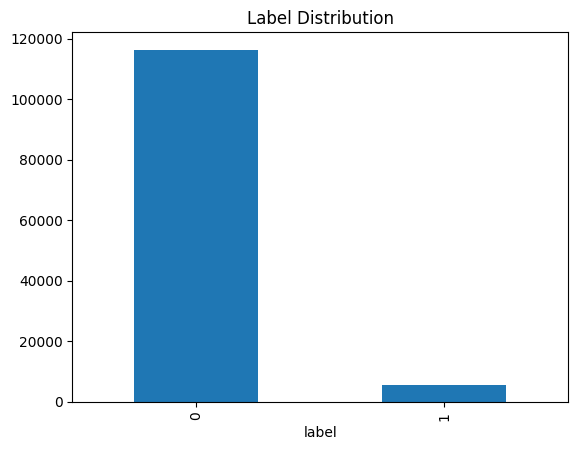

In [86]:
# Check the distribution of labels in labelled file 
label_dist = labelled['label'].value_counts()
print(label_dist)

# distribution of labels as percentage
label_dist_percentage = labelled['label'].value_counts(normalize = True)
print(label_dist_percentage)

# visualize the distribution using a bar plot
label_dist.plot(kind='bar', title='Label Distribution')

3. Merging labelled with mean_agg_data

In [87]:
merged_data = pd.merge(agg_data, labelled, how='left', on=["transcript_id","transcript_position"])

In [ ]:
# merged_data.head

Look at the imbalance of labels in the merged dataframe:
proportion of labels same as before merged

label
0    10527532
1      499574
Name: count, dtype: int64
label
0    0.954696
1    0.045304
Name: proportion, dtype: float64


<Axes: title={'center': 'Label Distribution'}, xlabel='label'>

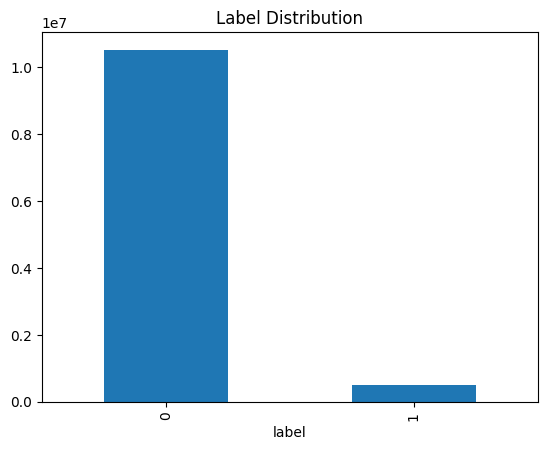

In [88]:
# Check the distribution of labels in labelled file 
label_dist = merged_data['label'].value_counts()
print(label_dist)

# distribution of labels as percentage
label_dist_percentage = merged_data['label'].value_counts(normalize = True)
print(label_dist_percentage)

# visualize the distribution using a bar plot
label_dist.plot(kind='bar', title='Label Distribution')

4. Train, test split of merged_data
- splitting should be done based on genes and not transcript

In [89]:
# split by gene
x = merged_data.drop('label', axis=1)
y = merged_data.label

gss = GroupShuffleSplit(n_splits=2, random_state=0)
x_train_i, x_test_i = next(gss.split(x,y,groups=x.gene_id))

x_train = x.loc[x_train_i]
y_train = y.loc[x_train_i]

x_test = x.loc[x_test_i]
y_test = y.loc[x_test_i]

In [38]:
# print(np.unique(x_train.gene_id).size) #number of unique gene ids in train
# print(np.unique(x_test.gene_id).size) #number of unique gene ids in test

3081
771


In [90]:
# intiating sets to check if unique ids in train and test
x_train_set = set(x_train)
x_test_set = set(x_test)
print(set.intersection(x_train_set, x_test_set))

{'transcript_id', 'dwelling_time_merged', 'nucleotide_seq', 'transcript_position', 'gene_id', 'mean_merged', 'sd_merged'}


In [75]:
#x_train.columns

Index(['transcript_id', 'transcript_position', 'nucleotide_seq',
       'dwelling_time_merged', 'sd_merged', 'mean_merged', 'gene_id'],
      dtype='object')

In [76]:
#print(x_train.loc[:, [1, "dwelling_time_merged", "sd_merged", "mean_merged"]].head)

In [ ]:
5. Model

In [91]:
# logistic regression model

# instantiate
logreg = LogisticRegression()

# fit model with data, selected following variables: "transcript_position", "dwelling_time_merged", "sd_merged", "mean_merged"

logreg.fit(x_train.loc[:, ["transcript_position", "dwelling_time_merged", "sd_merged", "mean_merged"]], y_train)

y_pred = logreg.predict(x_test.loc[:, ["transcript_position", "dwelling_time_merged", "sd_merged", "mean_merged"]])
y_pred_prob = logreg.predict_proba(x_test.loc[:, ["transcript_position", "dwelling_time_merged", "sd_merged", "mean_merged"]])

In [93]:
print(y_pred_prob[0:2]) #shows prob of classes 0, 1 respectively

[[0.95253977 0.04746023]
 [0.93029658 0.06970342]]


6. Evaluation metrics

In [94]:
# print(classification_report(y_test, y_pred))

target_names = ['no m6a modification', 'm6a modification'] # labels 0, 1
print(classification_report(y_test, y_pred, target_names=target_names))

c:\Users\yilin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yilin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                     precision    recall  f1-score   support

no m6a modification       0.95      1.00      0.98   1925773
   m6a modification       0.00      0.00      0.00     95698

           accuracy                           0.95   2021471
          macro avg       0.48      0.50      0.49   2021471
       weighted avg       0.91      0.95      0.93   2021471



c:\Users\yilin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 427.9555555555555, 'Predicted label')

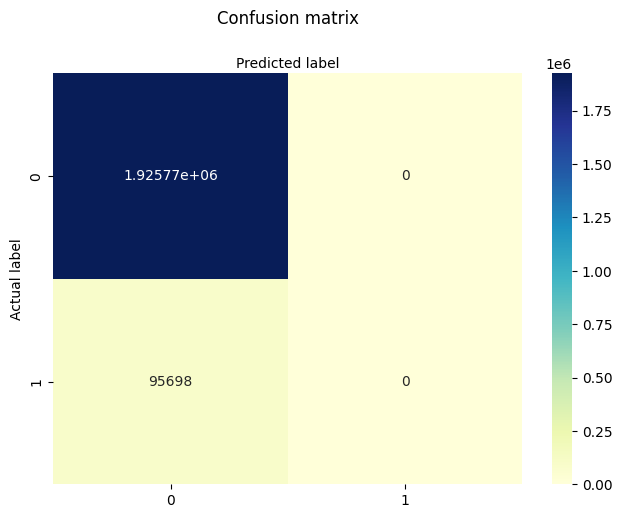

In [96]:
# plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
